# Investment Recommendation Model

## 1. Objective
The objective of this notebook is to develop an investment recommendation system based on historical user behavior. By identifying patterns among users with similar investment preferences, the model aims to suggest suitable asset allocation strategies for new users.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

## 2. Load Prepared Dataset
The cleaned user investment dataset generated during the exploratory data analysis phase is loaded here. This ensures consistency between analysis and modeling stages.

In [2]:
df_users = pd.read_csv("data/users_cleaned.csv")
df_users.head(2)

,gender,age,Investment_Avenues,Mutual_Funds,Equity_Market,Debentures,Government_Bonds,Fixed_Deposits,PPF,Gold,...,Duration,Invest_Monitor,Expect,Avenue,What are your savings objectives?,Reason_Equity,Reason_Mutual,Reason_Bonds,Reason_FD,Source
0,Male,29,Yes,2,4,7,5,3,1,6,...,Less than 1 year,Weekly,20%-30%,Public Provident Fund,Health Care,Dividend,Fund Diversification,Assured Returns,Fixed Returns,Newspapers and Magazines
1,Male,28,Yes,2,3,6,5,1,4,7,...,Less than 1 year,Weekly,30%-40%,Public Provident Fund,Retirement Plan,Capital Appreciation,Better Returns,Assured Returns,Risk Free,Television


## 3. Feature Selection
For the recommendation task, features are selected that reflect user demographics and investment preferences. These variables capture how users allocate investments across different asset classes and form the basis for user similarity.


In [3]:
investment_cols = [
    'Mutual_Funds', 'Equity_Market', 'Debentures',
    'Government_Bonds', 'Fixed_Deposits', 'PPF', 'Gold'
]

features = df_users[['age'] + investment_cols]
features.head(2)

,age,Mutual_Funds,Equity_Market,Debentures,Government_Bonds,Fixed_Deposits,PPF,Gold
0,29,2,4,7,5,3,1,6
1,28,2,3,6,5,1,4,7


## 4. Feature Scaling
KMeans clustering is distance-based and therefore sensitive to feature scale. All selected features are standardized to ensure that no single variable dominates the clustering process.

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

## 5. Determining the Optimal Number of Clusters
The elbow method is used to identify a suitable number of clusters. This helps balance model simplicity and representational accuracy.

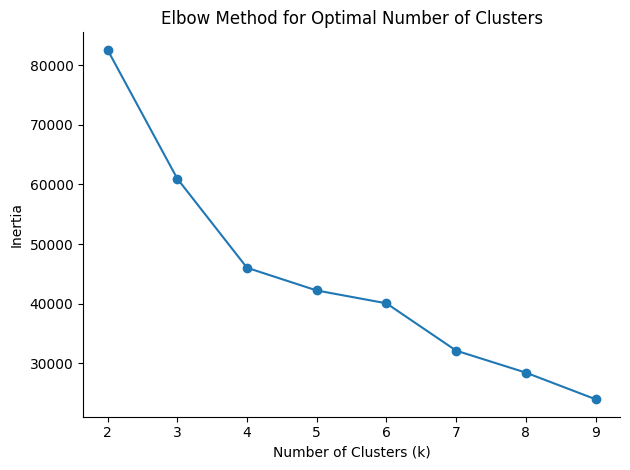

In [5]:
inertia = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

fig, ax = plt.subplots()
ax.plot(range(2, 10), inertia, marker='o')
ax.set_title("Elbow Method for Optimal Number of Clusters")
ax.set_xlabel("Number of Clusters (k)")
ax.set_ylabel("Inertia")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(False)

plt.tight_layout()
plt.show()

## 6. Model Training
Based on the elbow method, a suitable number of clusters is selected. The KMeans algorithm is then trained to group users with similar investment behaviors.

In [6]:
k = 4

kmeans_model = KMeans(n_clusters=k, random_state=42)
clusters = kmeans_model.fit_predict(X_scaled)

df_users['Cluster'] = clusters
df_users.head(2)

,gender,age,Investment_Avenues,Mutual_Funds,Equity_Market,Debentures,Government_Bonds,Fixed_Deposits,PPF,Gold,...,Invest_Monitor,Expect,Avenue,What are your savings objectives?,Reason_Equity,Reason_Mutual,Reason_Bonds,Reason_FD,Source,Cluster
0,Male,29,Yes,2,4,7,5,3,1,6,...,Weekly,20%-30%,Public Provident Fund,Health Care,Dividend,Fund Diversification,Assured Returns,Fixed Returns,Newspapers and Magazines,1
1,Male,28,Yes,2,3,6,5,1,4,7,...,Weekly,30%-40%,Public Provident Fund,Retirement Plan,Capital Appreciation,Better Returns,Assured Returns,Risk Free,Television,1


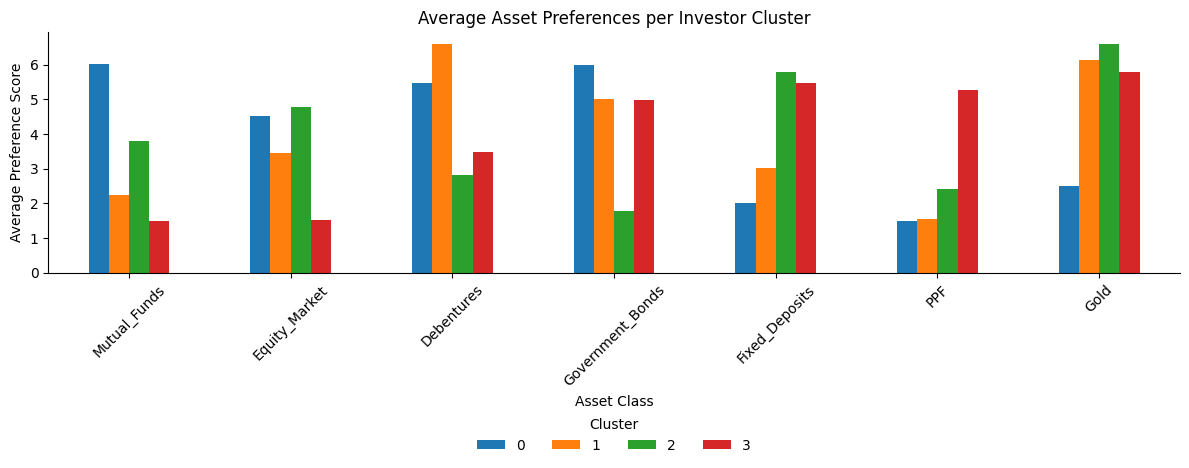

In [15]:
asset_cols = [
    'Mutual_Funds', 'Equity_Market', 'Debentures',
    'Government_Bonds', 'Fixed_Deposits', 'PPF', 'Gold'
]

cluster_means = df_users.groupby('Cluster')[asset_cols].mean()

ax = cluster_means.T.plot(
    kind='bar',
    figsize=(12, 6)
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.grid(False)

ax.set_title('Average Asset Preferences per Investor Cluster')
ax.set_xlabel('Asset Class')
ax.set_ylabel('Average Preference Score')

plt.xticks(rotation=45)

ax.legend(
    title='Cluster',
    loc='upper center',
    bbox_to_anchor=(0.5, -0.55),
    ncol=len(cluster_means),
    frameon=False
)

plt.tight_layout()
plt.show()

## 7. Cluster Interpretation
To understand the characteristics of each cluster, average investment preferences are calculated. This step allows meaningful interpretation of cluster-based recommendations.

In [7]:
cluster_profiles = df_users.groupby('Cluster')[investment_cols].mean()
cluster_profiles

,Mutual_Funds,Equity_Market,Debentures,Government_Bonds,Fixed_Deposits,PPF,Gold
Cluster,,,,,,,
0,6.017241,4.508621,5.474138,6.000000,2.017241,1.491379,2.491379
1,2.245506,3.442548,6.594312,5.003641,3.033902,1.548464,6.131627
2,3.793662,4.790845,2.812676,1.792254,5.777465,2.421831,6.611268
3,1.487603,1.512397,3.471074,4.989256,5.482645,5.262810,5.794215


### Cluster Analysis
The resulting clusters exhibit distinct investment behavior patterns. Each cluster represents a different investor profile, ranging from conservative, fixed-income-focused users to more growth-oriented investors with higher equity and gold exposure. These profiles enable interpretable and personalized investment recommendations.

## 8. Recommendation Logic
Each cluster represents a typical investment profile. New users can be assigned to the nearest cluster, and the average asset allocation of that cluster can be used as a personalized investment recommendation.

## 9. Saving the Trained Model
The trained clustering model and scaler are saved for use in the deployed application. This allows real-time recommendations without retraining the model.

In [8]:
os.makedirs("models", exist_ok=True)

joblib.dump(kmeans_model, "models/kmeans_recommender.pkl")
joblib.dump(scaler, "models/recommender_scaler.pkl")

['models/recommender_scaler.pkl']

## 10. Summary
This notebook implemented a clustering-based investment recommendation system using KMeans. User investment behaviors were grouped into meaningful clusters, forming the foundation for personalized portfolio suggestions in the deployed application.